In [1]:
import networkx as nx
import igraph as ig
import matplotlib.pyplot as plt
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
from collections import defaultdict
from operator import itemgetter
import pandas as pd
import collections
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# PART 1: EPIDEMIC PROCESS ON A SOCIAL NETWORK (8 points)

In [2]:
N = 868

In [3]:
# G = nx.barabasi_albert_graph(N, 2)
# Gc = max(nx.connected_component_subgraphs(G), key=len) ## Getting the giant subgraph

In [4]:
Gc = nx.read_gml('output/g.gml', label='id')
N = Gc.number_of_nodes()

In [5]:
number_nodes = Gc.number_of_nodes()
number_links = Gc.number_of_edges()

erg = ig.Graph.Erdos_Renyi(n=number_nodes, m=number_links, directed=False)

In [10]:
#function for plotting degree distribution
def plotDegreeDistribution(G):
    degs = defaultdict(int)
    for i in G.degree(): degs[i]+=1   #get all degree of each node into a dictionary
    items = sorted ( degs.items () ) # sort the values in dictionary
    x, y = np.array(items).T 
    y = [float(i) / sum(y) for i in y]
    plt.plot(x, y, 'bo')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend(['Degree'])
    plt.grid() #switch on grid
    plt.xlabel('Nodes', fontsize=18)
    plt.ylabel('probabilty distibution', fontsize=18)
    plt.show()

# plotDegreeDistribution(Gc)

Question 1.2 - Setting up a simulation of an SIR epidemic process starting from a randomly chosen node

In [11]:
class SIRSimulator:
    def __init__(self, graph, beta=0.25, mu=0.05):
        self.g = graph   
        self.BETA = beta
        self.MU = mu
        
    def run(self, seed=[], num_steps=1):
        # if no seed is specified, choose 1 node at random
        if not len(seed):
            seed = [ np.random.choice(self.g.nodes()) ]
            
        # initialize sets of S/I/R nodes
        I_set = set(seed)
        S_set = set(self.g.nodes()).difference(I_set)
        R_set = set()
        t = 0
        
        StoI_set = set(seed) # nodes that underwent S->I transition
        ItoR_set = set() # nodes that underwent I->R transition
 
        while True:
            # generator logic: yield current status every num_steps iterations
            if t % num_steps == 0:
                yield { 't': t, 'S': S_set, 'I': I_set, 'R': R_set,
                       'S->I': StoI_set, 'I->R': ItoR_set }
            
            # stop when there are no infectious nodes left
            if not len(I_set):
                break

            StoI_set = set()
            ItoR_set = set()
            
            # loop over neighbors of infectious nodes
            for i in set(I_set):
                # TRANSMISSION
                for j in S_set.intersection(self.g.neighbors(i)):
                    if np.random.uniform() < self.BETA:
                        S_set.remove(j)
                        I_set.add(j)
                        StoI_set.add(j)
                        
                # RECOVERY
                if np.random.uniform() < self.MU:
                    I_set.remove(i)
                    R_set.add(i)
                    ItoR_set.add(i)
      
            t += 1
  


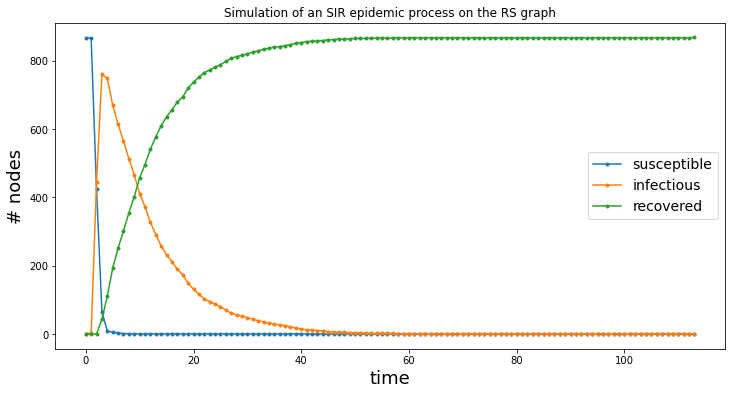

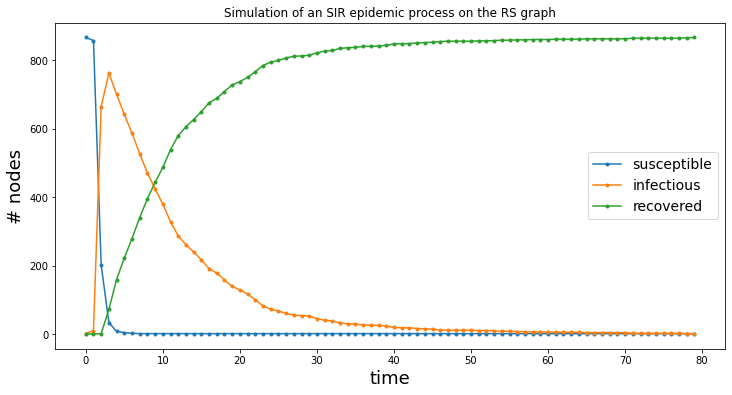

In [12]:
#The code to run two simulations of the epidermic
for ii in range(2):
    SIR = SIRSimulator(Gc, beta=0.6, mu=0.1)
    plt.figure(figsize=(12,6))

    # notice: this is a single realization and the epidemic might not take off
    plt.plot([ (len(status['S']), len(status['I']),len(status['R'])) for status in SIR.run()], '.-')
    plt.xlabel('time', fontsize=18)
    plt.ylabel('# nodes', fontsize=18)
    plt.title('Simulation of an SIR epidemic process on the RS graph')
    plt.legend(['susceptible', 'infectious', 'recovered'], fontsize=14, loc=7)


Question 1.3 plots of epidemic curves for multiple stochastic realizations of the epidemic using box plots to show 
             the overal attack rates 

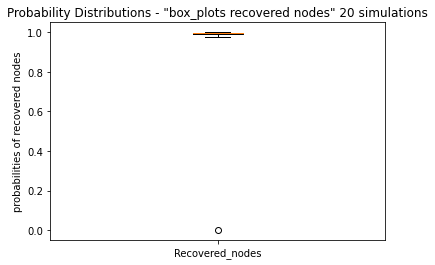

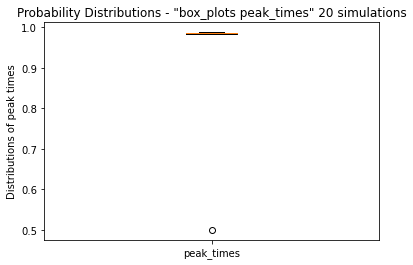

In [13]:
#methods for making the box plots 
def box_plots(Gc):
    p_time = []
    recovered = []
    for sim in range(20):
        SIR = SIRSimulator(Gc, beta=0.6, mu=0.1)
        # notice: this is a single realization and the epidemic might not take off
        all_data = [[len(status['I']),len(status['R']), status['t']] for status in SIR.run()]
        infected = [i[0] for i in all_data]
        t_time = len(infected)
        ##get the probabilities according to number of nodes for recovered and total time for peak_times
        recovered.append(np.max([i[1] for i in all_data])/len(Gc))
        p_time.append(np.max([i[2]/t_time for i in all_data]))
    # Create a figure instance recovered nodes
    fig = plt.figure(1, figsize=(6, 4))
    # Create an axes instance
    ax = fig.add_subplot(111)
    # Create the boxplot
    r_plot = ax.boxplot(recovered)
    # putting the labels on the x_axes
    ax.set_xticklabels(['Recovered_nodes'])
    ax.set_title('Probability Distributions - "box_plots recovered nodes" 20 simulations')
    ax.set_xlabel('')
    ax.set_ylabel('probabilities of recovered nodes')
    plt.show()
    # Create a figure instance for peak times
    fig2 = plt.figure(1, figsize=(6, 4))
    # Create an axes instance
    ax = fig2.add_subplot(111)
    # Create the boxplot
    t_plot = ax.boxplot(p_time)
    # putting the labels on the x_axes
    ax.set_xticklabels(['peak_times'])
    ax.set_title('Probability Distributions - "box_plots peak_times" 20 simulations')
    ax.set_xlabel('')
    ax.set_ylabel('Distributions of peak times')
    
    plt.show()

box_plots(Gc)


# PART 2: VACCINATION AND HERD IMMUNITY (10 points)

2.1 - Modify the simulation above so that it supports a given initial fraction r of randomly chosen "immunized" nodes, i.e., nodes that cannot be infected. Can you provide an upper bound for the overall attack rate without having to simulate the epidemic?

Answer: The modified simulation code is as below with number of nodes according to probability as already    vaccinated. 
Therefore the upperbound is given as;



α  = Attack Rate

N = Total Nodes

r = Fraction of immunized nodes

$$\alpha = \frac{N - (N*r)}{N}$$

In [14]:

class SIRSimulator2:
    def __init__(self, graph, beta=0.25, mu=0.05, prb = 0.3):
        self.g = graph   
        self.BETA = beta
        self.MU = mu
        self.prob = prb
        self.N = len(nx.nodes(graph))
        
    def run(self, seed=[], num_steps=1):
        #sample random vacinated nodes
        num_v = int(self.prob * self.N)
        r = [i for i in np.random.choice(self.g.nodes(), num_v)]
        # if no seed is specified, choose 1 node at random
        if not len(seed):
            seed = [ np.random.choice(self.g.nodes())]
            
        # initialize sets of S/I/R/V nodes
        V_set = set(r)
        I_set = set(seed)
        S_set = set(self.g.nodes()).difference(I_set)
        R_set = set()
        t = 0
        
        StoI_set = set(seed) # nodes that underwent S->I transition
        ItoR_set = set() # nodes that underwent I->R transition
        VtoV_set = set() # nodes that was checked but vaccinated 
 
        while True:
            # generator logic: yield current status every num_steps iterations
            if t % num_steps == 0:
                yield { 't': t, 'S': S_set, 'I': I_set, 'R': R_set,
                       'S->I': StoI_set, 'I->R': ItoR_set,'V':VtoV_set}
            
            # stop when there are no infectious nodes left
            if not len(I_set):
                break

            StoI_set = set()
            ItoR_set = set()
            VtoV_set = set() # nodes that was checked but vaccinated
            
            # loop over neighbors of infectious nodes
            for i in set(I_set):
                # TRANSMISSION IF NODE NOT IN VACCINATED SET
                for j in S_set.intersection(self.g.neighbors(i)):
                    if (np.random.uniform() < self.BETA):
                        if(j in V_set):    
                            VtoV_set.add(j)
                        else:
                            S_set.remove(j)
                            I_set.add(j)
                            StoI_set.add(j)
                        
                # RECOVERY
                if np.random.uniform() < self.MU:
                    I_set.remove(i)
                    R_set.add(i)
                    ItoR_set.add(i)
      
            t += 1
  



Question 2.2 - For a range of values of the initial fraction of immunized nodes (e.g., r = 0.01, 0.1, 0.5, 0.8, 0.9, ...) simulate the SIR epidemic above (multiple realizations for each value of r) and plot the overall attack rate as a function of the fraction r of immunized nodes.


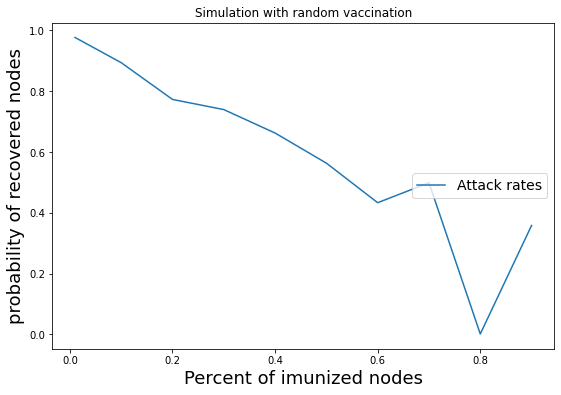

In [15]:

def r_plots(graph):
    prob = [0.01, 0.1,0.2,0.3,0.4,0.5,0.6,0.7, 0.8, 0.9]
    y = []
    for pr in prob:
        SIR = SIRSimulator2(graph, beta=0.6,mu=0.1,prb=pr)
        # notice: this is a single realization and the epidemic might not take off
        all_data = [[len(status['I']),len(status['R'])] for status in SIR.run()]
        infected = [i[0] for i in all_data]
        ##get the probabilities according to number of nodes for recovered and total time for peak_times
        y.append(np.max([i[1] for i in all_data])/N)
    fig = plt.figure(1, figsize=(9, 6))
    # Create an axes instance
    ax = fig.add_subplot(111)

    # Create the plot
    plt.plot(prob, y)
    # putting the labels on the x_axes
    ax.set_title('Simulation with random vaccination')
    ax.set_xlabel('Percent of imunized nodes', fontsize=18)
    ax.set_ylabel('probability of recovered nodes', fontsize=18)
    plt.legend(['Attack rates'], fontsize=14, loc=7)
    plt.show()
r_plots(Gc)



Question 2.3 - Generate a random Erdős–Rényi and  Repeat the experiment 2.2 above. 
  Compare the results you obtain in this case and in the previous case, and explain the differences you observe.

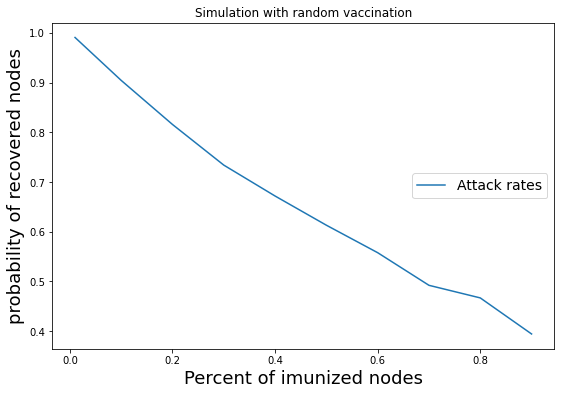

In [18]:
#Generate graph and draw plots
eG=nx.erdos_renyi_graph(N, 0.6, seed=None, directed=False)

connected_component_subgraphs = (eG.subgraph(c) for c in nx.connected_components(eG))

eG = max(connected_component_subgraphs, key=len) ## Getting the giant subgraph

r_plots(eG)

Answer 2.3: From the observation of the two different plots from Erdős–Rényi and Barabasi-Albert graphs we observed:
        
1. The probability distributions of overall attack rates in Erdős–Rényi graphs are by far less than that of Barabasi-Albert for all the possible values of immunized nodes. This behaviour can be mostly attributed to the fact that Barabasi-Albert are more biased in connected nodes as connection usually favours node that started the network.
2. Barabasi-Albert graphs has shown much irregularity in the way the overall distribution of attack rates happens with respect to increasing the percentage of immunized nodes. On the contrary in Erdős–Rényi graphs the overall attack rates seems to fall smoothly following what seems like some linear curve which is an apparent indication of unbiaseness in the connection of nodes
          

# PART 3: TARGETED VACCINATION STRATEGIES (12 points)

Question 3.1 - Imagine that you have a "budget" of M vaccination doses, with M < N, where N is the size of your network.

Answer: The Strategy devised in this first part is to Vaccinated nodes with the highest degree which works in this  case as we know the network structure. However, in real life scenario this is not practical as we would not be able to know the network structure in advance for the spread of epidermics. We choose the number of nodes to vaccinate according to given percentage r

In [19]:

class SIRSimulator3:
    def __init__(self, graph, beta=0.25, mu=0.05, prb = 0.10):
        self.g = graph   
        self.BETA = beta
        self.MU = mu
        self.prob = prb
        self.N = len(nx.nodes(graph))
        
    def run(self, seed=[], num_steps=1):
        #sample vaccinated nodes with the highest number of degree distribution
        num_v = int(self.prob * self.N)
        r = [sorted(nx.degree(Gc), key=nx.degree(Gc).__getitem__, reverse=True)[i] for i in range(4)]
        # if no seed is specified, choose 1 node at random
        if not len(seed):
            seed = [ np.random.choice(self.g.nodes())]
            
        # initialize sets of S/I/R/V nodes
        V_set = set(r)
        I_set = set(seed)
        S_set = set(self.g.nodes()).difference(I_set)
        R_set = set()
        t = 0
        
        StoI_set = set(seed) # nodes that underwent S->I transition
        ItoR_set = set() # nodes that underwent I->R transition
        VtoV_set = set() # nodes that was checked but vaccinated 
 
        while True:
            # generator logic: yield current status every num_steps iterations
            if t % num_steps == 0:
                yield { 't': t, 'S': S_set, 'I': I_set, 'R': R_set,
                       'S->I': StoI_set, 'I->R': ItoR_set,'V':VtoV_set}
            
            # stop when there are no infectious nodes left
            if not len(I_set):
                break

            StoI_set = set()
            ItoR_set = set()
            VtoV_set = set() # nodes that was checked but vaccinated
            
            # loop over neighbors of infectious nodes
            for i in set(I_set):
                # TRANSMISSION IF NODE NOT IN VACCINATED SET
                for j in S_set.intersection(self.g.neighbors(i)):
                    if (np.random.uniform() < self.BETA):
                        if(j in V_set):    
                            VtoV_set.add(j)
                        else:
                            S_set.remove(j)
                            I_set.add(j)
                            StoI_set.add(j)
                        
                # RECOVERY
                if np.random.uniform() < self.MU:
                    I_set.remove(i)
                    R_set.add(i)
                    ItoR_set.add(i)
      
            t += 1
  



In [21]:
def r_plots(graph):
    prob = [0.01, 0.1,0.2,0.3,0.4,0.5,0.6,0.7, 0.8, 0.9]
    y = []
    for pr in prob:
        SIR = SIRSimulator3(graph, beta=0.6, mu=0.1,prb=pr)
        # notice: this is a single realization and the epidemic might not take off
        all_data = [[len(status['I']),len(status['R'])] for status in SIR.run()]
        infected = [i[0] for i in all_data]
        ##get the probabilities according to number of nodes for recovered and total time for peak_times
        y.append(np.max([i[1] for i in all_data])/N)
    fig = plt.figure(1, figsize=(9, 6))
    # Create an axes instance
    ax = fig.add_subplot(111)
    plt.plot(prob, y)
    # putting the labels on the x_axes
    ax.set_title('Ans 3.1:Simulation with percentage of immunized nodes')
    ax.set_xlabel('Percent of imunized nodes', fontsize=18)
    ax.set_ylabel('probability of recovered nodes', fontsize=18)
    plt.legend(['Attack rates'], fontsize=14, loc=7)
    plt.show()
    plt.show()
    
# r_plots(Gc)

Answer: From the above graph of strategic immunization in comparison to random immunization we observe that there is much improvement on the spread of the epidermic as the stops within a short possible time for all the possible number of immunized nodes especially with an increase in the number of immunized nodes. From the graph above when the percentage of immunized nodes is between 10% to 40% in takes some time to recover but from 40% to 90% there in less overall attacks and quick recovery.

Question 3.2 - Now imagine that you still have a limited budget of M vaccination doses, but you cannot use information about the graph to decide how to use it.

In [22]:
class SIRSimulator3:
    def __init__(self, graph, beta=0.25, mu=0.05):
        self.g = graph   
        self.BETA = beta
        self.MU = mu
        
    def run(self, seed=[], num_steps=1, mod = 1, vacc=0.2, vacSet = set()):
        # if no seed is specified, choose 1 node at random
        if not len(seed):
            seed = [ np.random.choice(self.g.nodes()) ]
            
        # initialize sets of S/I/R nodes
        I_set = set(seed)
        
        if mod == 1:
            V_set = set()
            S_set = set(self.g.nodes()).difference(I_set)
        elif mod == 2:
            V_set = set()
            rem = set(self.g.nodes()).difference(I_set)
            for t1 in range(int(vacc * len(self.g.nodes()))):
                V_set.update(random.sample(set(rem),1))
            S_set = set(self.g.nodes()).difference(I_set.union(V_set))
        elif mod == 3:
            V_set = vacSet
            S_set = set(self.g.nodes()).difference(I_set.union(V_set))
        #else:
        #    mmm = 1
        
        R_set = set()
        t = 0
        
        StoI_set = set(seed) # nodes that underwent S->I transition
        ItoR_set = set() # nodes that underwent I->R transition
 
        while True:
            # generator logic: yield current status every num_steps iterations
            if t % num_steps == 0:
                yield { 't': t, 'S': S_set, 'V': V_set, 'I': I_set, 'R': R_set,
                       'S->I': StoI_set, 'I->R': ItoR_set }
            
            # stop when there are no infectious nodes left
            if not len(I_set):
                break

            StoI_set = set()
            ItoR_set = set()
            
            # loop over neighbors of infectious nodes
            for i in set(I_set):
                # TRANSMISSION
                for j in S_set.intersection(self.g.neighbors(i)):
                    if np.random.uniform() < self.BETA:
                        S_set.remove(j)
                        I_set.add(j)
                        StoI_set.add(j)
                        
                # RECOVERY
                if np.random.uniform() < self.MU:
                    I_set.remove(i)
                    R_set.add(i)
                    ItoR_set.add(i)
      
            t += 1
  

In [23]:
#Build a dataframe of most connected nodes based on ratio neighbours/N, to be used as immunization base.
simu = SIRSimulator3(Gc, beta=0.6, mu=0.1)
prob = [0.01, 0.1, 0.5, 0.8, 0.9]
a31_mostConnNodes = []
for i in range(0,N):
    a31_mostConnNodes.append(len(list(Gc.neighbors(i)))/N)
a31_mostConnDf = pd.DataFrame({"Node":list(range(0, N)),"Ratio":a31_mostConnNodes})
a31_mostConnDf = a31_mostConnDf.sort_values("Ratio",ascending=False)

# Simulate SIR process 5 times for each fraction of r immunized nodes. Select immunized nodes based on rated 
# nodes dataframe. Collect number of recovered nodes at the end of each process and divide it with N to obtain
# attack ratio. a31_rVals -- rec_nodes

rec_nodes = []
for frac in prob:
    cnt = int(N*frac)
    md = a31_mostConnDf.iloc[0:cnt,0] 
    Vset = set(md)
    for k in range(5):
        for status in simu.run(mod=3,vacSet=Vset):
            rec = len(status['R'])
        rec_nodes.append(rec)

node_ratio1 = []
for i in range(len(rec_nodes)):
    node_ratio1.append(rec_nodes[i]/N)

In [24]:
#Build two counters, one to collect currently infected nodes in simulation and get multiplied by decreasing value
# as a proxy to time weighted rating and the other to keep cumulative value over time. Eventually move and sort
# results to data.frame which will serve as basis for selecting immunized nodes.
counter_1 = collections.Counter()
counter_2= collections.Counter()

for t in range(0,20):
    i = 500
    for status in simu.run():
            counter_1.update(status["I"])
            counter_2.update(list(counter_1.elements())*i)
            counter_1.clear()
            i = i - 10
            if i < 1:
                i = 1
a32_inferenceDf = pd.DataFrame.from_dict(counter_2, orient='index').reset_index()
a32_inferenceDf.columns = ["Node","Rating"]
a32_inferenceDf = a32_inferenceDf.sort_values("Rating",ascending=False)


In [25]:
# Simulate SIR process 5 times for each fraction of r immunized nodes. Select immunized nodes based on rated 
# nodes dataframe. Collect number of recovered nodes at the end of each process and divide it with N to obtain
# attack ratio. a32_rRatio - node_ratio
xLab = np.array(list(range(0, 25)))
xLab1 = ["1%","10%","50%","80%","90%"]*5
xLab1.sort()
recc_nodes = []
for frac in prob:
    a32_cnt = int(N*frac)
    a32_md = a32_inferenceDf.iloc[0:a32_cnt,0] 
    Vset = set(a32_md)
    for k in range(5):
        for status in simu.run(mod=3,vacSet=Vset):
            rec = len(status['R'])
        recc_nodes.append(rec)

node_ratio2 = []
for i in range(len(recc_nodes)):
    node_ratio2.append(recc_nodes[i]/N)

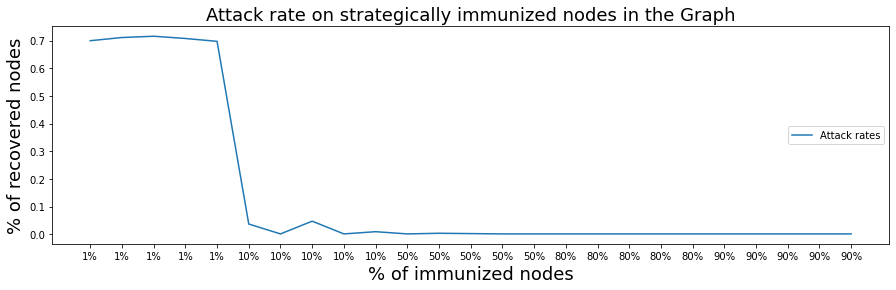

In [26]:
#Plotting, set the figure size, xlabel ticks, plot data, add title, x and y labels, legend

plt.figure(figsize=(15,4))
plt.xticks(xLab, xLab1)
plt.plot(xLab,node_ratio1);
plt.title('Attack rate on strategically immunized nodes in the Graph', fontsize=18);
plt.xlabel('% of immunized nodes', fontsize=18);
plt.ylabel('% of recovered nodes', fontsize=18);
plt.legend(['Attack rates'], fontsize=10, loc=7);

Answer 3.2:
Clearly from the graph we can infer that this strategy is prefered than the previous in 3.1 as can be seen that at exactly 50% of immunized nodes there is no spread of epidermic unlike that of 3.1

Question 3.3 - Finally, imagine that you have limited information about the social network: you are given a set of K nodes (K << N, say K ~ 10% of the network)

Answer: So in the scenario the targeted immunization strategy is to use the acquaintance system where we get a few nodes and find their neighbours and immunize a subset of the neighbours. Hence, here we change the simulation to to accept neighbors of given nodes k%:

In [27]:
class SIRSimulator4:
    def __init__(self, graph, beta=0.25, mu=0.05, prb = 0.3):
        self.g = graph   
        self.BETA = beta
        self.MU = mu
        self.prob = prb
        self.N = len(nx.nodes(graph))
        
    def run(self,  neighbors, seed=[], num_steps=1):
        #sample random vacinated nodes
        num_v = int(self.prob * self.N)
        r = [i for i in np.random.choice(neighbors, num_v)]
        # if no seed is specified, choose 1 node at random
        if not len(seed):
            seed = [ np.random.choice(self.g.nodes())]
            
        # initialize sets of S/I/R/V nodes
        V_set = set(r)
        I_set = set(seed)
        S_set = set(self.g.nodes()).difference(I_set)
        R_set = set()
        t = 0
        
        StoI_set = set(seed) # nodes that underwent S->I transition
        ItoR_set = set() # nodes that underwent I->R transition
        VtoV_set = set() # nodes that was checked but vaccinated 
 
        while True:
            # generator logic: yield current status every num_steps iterations
            if t % num_steps == 0:
                yield { 't': t, 'S': S_set, 'I': I_set, 'R': R_set,
                       'S->I': StoI_set, 'I->R': ItoR_set,'V':VtoV_set}
            
            # stop when there are no infectious nodes left
            if not len(I_set):
                break

            StoI_set = set()
            ItoR_set = set()
            VtoV_set = set() # nodes that was checked but vaccinated
            
            # loop over neighbors of infectious nodes
            for i in set(I_set):
                # TRANSMISSION IF NODE NOT IN VACCINATED SET
                for j in S_set.intersection(self.g.neighbors(i)):
                    if (np.random.uniform() < self.BETA):
                        if(j in V_set):    
                            VtoV_set.add(j)
                        else:
                            S_set.remove(j)
                            I_set.add(j)
                            StoI_set.add(j)
                        
                # RECOVERY
                if np.random.uniform() < self.MU:
                    I_set.remove(i)
                    R_set.add(i)
                    ItoR_set.add(i)
      
            t += 1
  


In [28]:
# 20% of nodes given and get their neigbors
k = int(len(Gc)*0.2)
k_nodes = [i for i in np.random.choice(Gc.nodes(), k)]
neighbors = []
for node in k_nodes:
    for n in Gc.neighbors(node):
        neighbors.append(n)
print(k)
print(len(neighbors))
#from here we have to make plots vaccinating nodes chosen at rondom from the neighbors but less or equall to k

173
1474


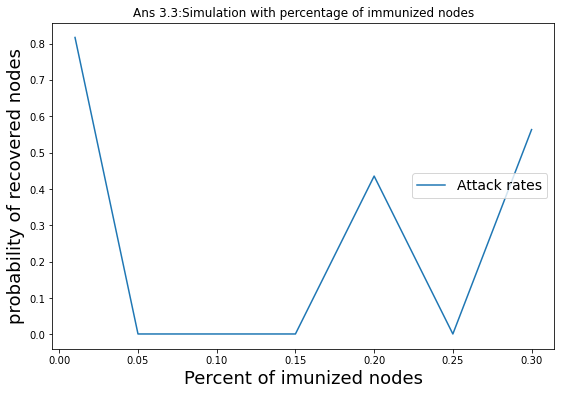

In [29]:
def r_plots(graph):
    prob = [0.01,0.05, 0.1,0.15, 0.2,0.25,0.3]
    y = []
    for pr in prob:
        SIR = SIRSimulator4(graph, beta=0.6, mu=0.1,prb=pr)
        # notice: this is a single realization and the epidemic might not take off
        all_data = [[len(status['I']),len(status['R'])] for status in SIR.run(neighbors)]
        infected = [i[0] for i in all_data]
        ##get the probabilities according to number of nodes for recovered and total time for peak_times
        y.append(np.max([i[1] for i in all_data])/N)
    fig = plt.figure(1, figsize=(9, 6))
    # Create an axes instance
    ax = fig.add_subplot(111)
    plt.plot(prob, y)
    # putting the labels on the x_axes
    ax.set_title('Ans 3.3:Simulation with percentage of immunized nodes')
    ax.set_xlabel('Percent of imunized nodes', fontsize=18)
    ax.set_ylabel('probability of recovered nodes', fontsize=18)
    plt.legend(['Attack rates'], fontsize=14, loc=7)
    plt.show()
    plt.show()
r_plots(Gc)

Answer: The graph above depicts that there is great improvement in this targetted strategy as compared to previous ones in the sense that with even less number of vaccinated nodes there is less overall attack rates as seen from 10% to only 30% of immunized nodes while in the prevoius scenarios the curves showed quick drops from 40% of vaccinated nodes.